Generate my own data $x_i \sim \mbox{Gamma}(\alpha=1.5, \beta=60)$ and check that my method recover this. Use fairly few samples, and use only one term in $\alpha$ and $\beta$ polynomials. No need to transform from $\ell \to x$, we generate in $x$ directly

In [8]:
import Distributions, PyCall, TardisStats
using FredPlots

INFO: Recompiling stale cache file /home/beaujean/.julia/lib/v0.5/LaTeXStrings.ji for module LaTeXStrings.
INFO: Recompiling stale cache file /home/beaujean/.julia/lib/v0.5/PyPlot.ji for module PyPlot.
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
α0 = 1.5; β0 = 60.; λ0 = 500
νmin=0.
νmax=10.

10.0

Do we need to make up frequencies? Not really, we just care about one bin, but for compatibility, we do

In [11]:
reload("TardisStats")

# define order of linear models
αOrder = 1
βOrder = 1
npackets=1000

# read in data from tardis and create posterior
dim = αOrder + βOrder
∇res, Hres = TardisStats.optim.allocations(dim)
frame, (P, ∇P!, HP!) = TardisStats.optim.problem(αOrder=αOrder, βOrder=βOrder, run=99, npackets=npackets);

# now change the energies
PyCall.@pyimport numpy.random as nprand
nprand.seed(1358)
PyCall.@pyimport scipy.stats as stats
dist0 = stats.gamma(α0, scale=1/β0)
# crucial: change frame in place, else optimization runs with old energies!
frame[:energies][:] = dist0[:rvs](size=length(frame[:energies]))
# Plots.histogram(frame[:energies])

# the observed number of packets in the bin
nmin=searchsortedfirst(frame[:nus], νmin)
nmax=searchsortedlast(frame[:nus], νmax)
n = nmax - nmin + 1
x = sum(frame[:energies][nmin:nmax])
n,x

# for testing
# n = 291
# x= 7.389999302674019

(731,18.697373359396096)

In [12]:
# compute the posterior mode to estimate the evidence
# start optimization at true values
@time maxP, posterior_mode, ret = TardisStats.optim.run_nlopt(frame, P, ∇P!, HP!,
    αOrder, βOrder, xtol_rel=1e-4, init=1.001*[α0, β0])
HP!(posterior_mode, Hres)
evidence = TardisStats.optim.laplace(maxP, Hres)
println("got $maxP at $(posterior_mode) (returned $ret) and evidence $evidence")

  0.359480 seconds (2.45 M allocations: 48.774 MB, 3.08% gc time)
got 1984.2698125710563 at [1.5286,59.7618] (returned XTOL_REACHED) and evidence 1984.0698984517023


Asymptotic
------

We will use all samples to compute the mean and variance but then focus on one $\nu$ bin to get the prediction as above

In [14]:
reload("TardisStats")
# variant 1: take samples from frequency bin
#index = searchsortedfirst(frame[:nus], νmin)
#samples = frame[:energies][index:index+n+1]

# variant 2: take all samples
samples = frame[:energies][nmin:nmax]

# compute moments
xmean, sumsqdiff = mean(samples), (n-1)*var(samples)
asymp_res = TardisStats.Asymptotic.uncertainty(n, xmean, sumsqdiff; a=1.)
distasympt=Distributions.Normal(asymp_res[1], asymp_res[2])
println(distasympt)

# compute range of interest from asymptotic approx.
points = collect(linspace(max( asymp_res[1] - 3asymp_res[2], 0.0), asymp_res[1] + 3asymp_res[2], 25))


LoadError: LoadError: Dual(731.073000009999,1.0,0.0,0.0)Dual(-1126.6932096209546,0.0,1.0,0.0)Dual(-2.1522045365746914e-7,0.0,0.0,1.0)
while loading In[14], in expression starting on line 11

In [20]:
reload("Asymptotic")
q=points[12]
println(q)
Asymptotic.uncertainty(n,xmean, sumsqdiff; a=1., Q=q)
#target = Asymptotic.targetfactory(Asymptotic.NormalAndPosterior, n, xmean, sumsqdiff; a=1., Q=18.7)
#Plots.plot(σSq->(x=[n, xmean, σSq]; exp(-target(x))), 0.0001:sumsqdiff/n/20:3*sumsqdiff/n)

#asympt_posterior = Float64[Asymptotic.uncertainty(n,xmean, sumsqdiff; a=1., Q=q) for q in points[1:end]]

      

LoadError: LoadError: UndefVarError: points not defined
while loading In[20], in expression starting on line 2

In [188]:
xmean

0.025577802133236783

In [170]:
sumsqdiff/n

0.0004247618154645813

In [171]:
Float64[q for q in points]

25-element Array{Float64,1}:
 13.0117
 13.4771
 13.9424
 14.4077
 14.873 
 15.3384
 15.8037
 16.269 
 16.7343
 17.1997
 17.665 
 18.1303
 18.5956
 19.061 
 19.5263
 19.9916
 20.4569
 20.9223
 21.3876
 21.8529
 22.3182
 22.7836
 23.2489
 23.7142
 24.1795

Sum over N
----

In [19]:
# compute the posterior mode to estimate the evidence
# start optimization at true values
@time maxP, posterior_mode, ret = TardisStats.optim.run_nlopt(frame, P, ∇P!, HP!,
    αOrder, βOrder, xtol_rel=1e-3, init=1.001*[α0, β0])
HP!(posterior_mode, Hres)
evidence = TardisStats.optim.laplace(maxP, Hres)
println("got $maxP at $(posterior_mode) (returned $ret) and evidence $evidence")

  0.155934 seconds (1.26 M allocations: 21.081 MB)
got 1984.2647228869678 at [1.52229,59.5826] (returned XTOL_REACHED) and evidence 1984.05942696338


The mode matches the input values well

In [22]:
# the posterior mean with the normalized posterior
# predict at bin center
# ν, X, N
#pm = optim.PosteriorMean((νmax + νmin)/2, x, convert(Float64, n))
pm = TardisStats.optim.PosteriorMean(1.0, x, convert(Float64, n))
Pmean, ∇Pmean!, HPmean! = TardisStats.optim.targetfactory(frame, αOrder, βOrder, evidence=evidence, pm=pm)
@time maxPmean, mean_mode, ret = TardisStats.optim.run_nlopt(frame, Pmean, ∇Pmean!, HPmean!, αOrder, βOrder,
init=posterior_mode, xtol_rel=1e-6)
println("max of normalized posterior = $maxPmean at $(mean_mode), returned $ret")

# n, a
nb = TardisStats.optim.NegBinom(n, 1.);

  0.258962 seconds (6.27 M allocations: 96.073 MB, 4.51% gc time)
max of normalized posterior = -0.12714236803253698 at [1.53085,59.8508], returned XTOL_REACHED


The **mode comes out pretty much at the input values** 

In [24]:
#points = collect(linspace(max(x-4, 0.0), x+1, 25))
distn = stats.gamma(n*α0, scale=1/β0)
points = collect(linspace(distn[:ppf](1e-6), dist0[:ppf](1-1e-6), 25))
results = zeros(points)
# skip X = 0, start at 2
for i in 2:length(points)
    pm.X = points[i]
    results[i] = TardisStats.optim.predict_small(frame, Pmean, ∇Pmean!, HPmean!, pm, αOrder, βOrder, posterior_mode,
    nb, optimize=false)
end

initial N=627
initial N=608
initial N=584
initial N=564
initial N=543
initial N=522
initial N=505
initial N=482
initial N=461
initial N=440
initial N=418
initial N=397
initial N=375
initial N=350
initial N=326
initial N=303
initial N=277
initial N=252
initial N=224
initial N=197
initial N=166
initial N=132
initial N=94
initial N=43


In [25]:
simp = tardis.simpson(points, results)
info("Simpson: normalization=$(simp[1]), mean=$(simp[2]), σ=$(simp[3])")
results /= simp[1]
# now repeat to get the right σ
simp = tardis.simpson(points, results)
info("Simpson: normalization=$(simp[1]), mean=$(simp[2]), σ=$(simp[3])")


LoadError: LoadError: DomainError:
sqrt will only return a complex result if called with a complex argument. Try sqrt(complex(x)).
while loading In[25], in expression starting on line 1

Plot and compare
----


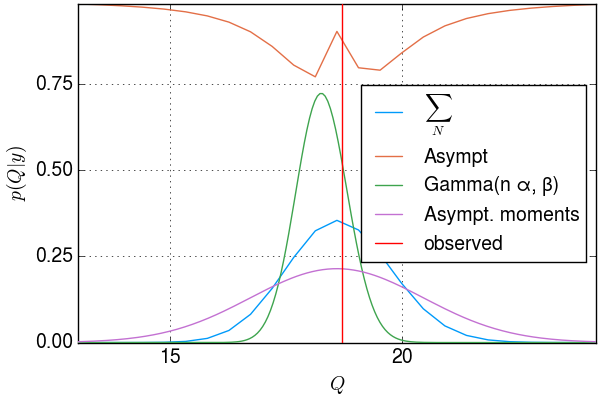

In [176]:
using LaTeXStrings, StatPlots
compare = function(points, results, asympt_results, x; distn=nothing, distasympt=nothing)
    Plots.plot(points, results, xlabel=L"Q", ylabel=L"p(Q | y)", label=L"\sum_N")
    Plots.plot!(points, asympt_results, label="Asympt")
    finepoints = collect(linspace(points[1], points[end], 200))
    if distn !== nothing        
        Plots.plot!(finepoints, distn[:pdf](finepoints), label="Gamma(n α, β)")
    end
    if distasympt !== nothing
        Plots.plot!(finepoints, Distributions.pdf(distasympt, finepoints),
        label="Asympt. moments")
    end
    # vline at the end to plot all the way
    Plots.vline!([x], line=:red, label="observed")
end

compare(points, results, asympt_posterior, x; distn=distn, distasympt=distasympt)

In [177]:
n

731


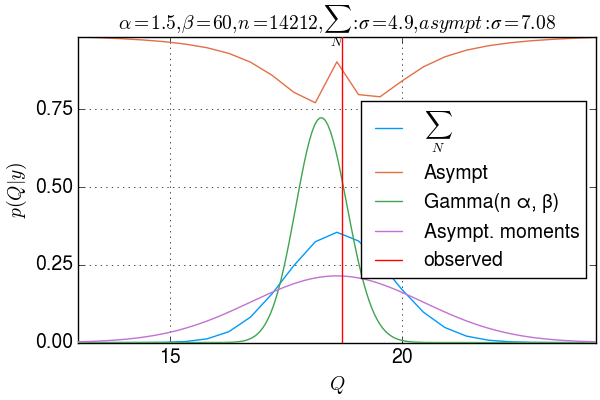

In [178]:
plot!(title=L"\alpha=1.5, \beta=60, n=14212, \sum_N: σ=4.9, asympt: σ=7.08", )
Plots.pdf("Qcompare-n14212")
plot!()

where does the variance come from
-----

If we use only 1000 instead of 10000 samples, prediction nearly identical $\Rightarrow$ broadening is due to the Poisson term

For compound Poisson,
$$V[Q] = V[X] \lambda + E[X^2] \lambda = \lambda E[X^2]$$

and for large $\lambda$, $\lambda \approx n$, so variance of compound 
$$V[Q] \propto n$$, so how well is Q known from $n$ samples? The usual answer
$$\sqrt{V[Q]}/Q \propto 1/\sqrt{n}$$

In [179]:
α0 / β0^2 * n, α0 / β0^2 *(1 + α0)

(0.3045833333333334,0.0010416666666666667)

Check optimizer
------

Is cobyla not working right?

In [180]:
using Optim

optimize(x->-P(x), 1.05*[α0, β0], BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [1.5750000000000002,63.0]
 * Minimizer: [1.5291337348696112,59.783625153979244]
 * Minimum: -1.984270e+03
 * Iterations: 6
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 27
 * Gradient Calls: 27

In [181]:
α0/β0^2 *(length(frame[:energies])-1)

0.3041666666666667


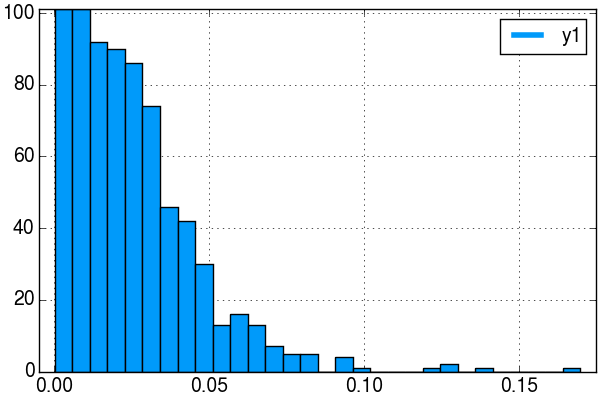

In [182]:
Plots.histogram(frame[:energies])

In [183]:
reload("Asymptotic")
asymp_res = Asymptotic.uncertainty(n, xmean, sumsqdiff, 0.)

compare(points, results, x; distn=distn)
Plots.plot!(distasympt, label=L"\mathcal{N}")

LoadError: LoadError: MethodError: no method matching uncertainty(::Int64, ::Float64, ::Float64, ::Float64)
Closest candidates are:
  uncertainty(::Int64, ::Float64, ::Float64; a, Q) at /home/beaujean/workspace/tardis-sn/statistics-notes/real/code/Asymptotic.jl:139
while loading In[183], in expression starting on line 2

Unit test
======


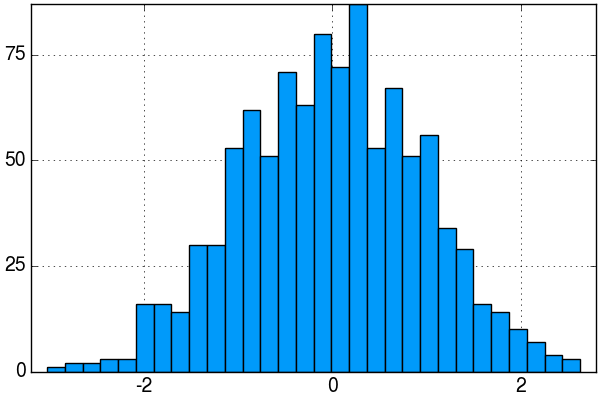

In [5]:
Plots.histogram(randn(1000))

Plot the posterior on $\mu$ and $\sigma^2$
----

Looks very Gaussian, so the Laplace integration should work fine

In [1]:
function make_log_posterior(n, μ_n, a_n, b_n)
#    log_posterior(x::Vector) = begin
#        μ, σSq = x
    log_posterior(μ, σSq) = begin
        -1/2*(log(2π*σSq / n) +(μ - μ_n)^2 / σSq * n) +
        (a_n * log(b_n) - lgamma(a_n) - (a_n + 1) * log(σSq) - b_n / σSq)
    end
end

make_log_posterior (generic function with 1 method)


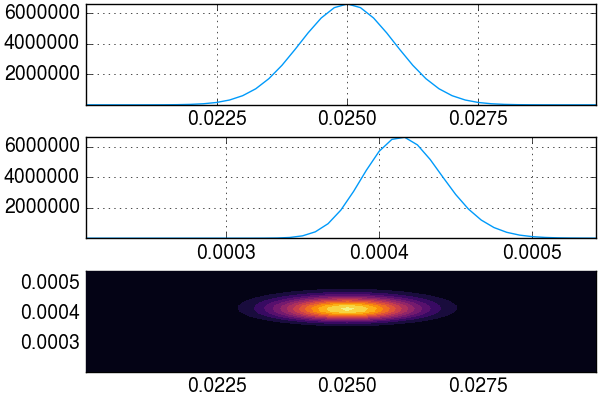

In [6]:
begin
    f = make_log_posterior(λ0, α0/β0, λ0/2, λ0/2 * α0/β0^2)
    harr=α0/β0
    μs = collect(0.8harr:harr/100:1.2*harr)
    σSqs = collect(0.000416666/2:0.000416666/50:1.3*0.000416666)
    layout=(3,1)
    Plots.plot(μs, μ -> exp(f(μ, α0/β0^2)),layout=layout)
    Plots.plot!(σSqs, σSq -> exp(f(harr, σSq)),layout=layout, subplot=2)
    Plots.plot!(μs, σSqs, (μ, σSq) -> exp(f(μ, σSq)), st=:contourf, 
                layout=layout, subplot=3)
end